# MS-AAI-501: Intro to AI
## Final Project:  Airline Flight Delay Analysis and Modeling
### File Name:  Logistic Regression.jpynb
### Date:  12/4/2023
### Author:  Ned Kost

In [71]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import category_encoders as ce


In [41]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()

# Reducing dimensionality of TimeZones 
def binary_encode_timezone(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

# Reducing dimensionality of TimeZones 
def binary_encode_timezone(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

def calculate_crsDeptTime(dept, delay):
    s = str(int(dept))
    if(len(s) < 3):
        t =  dt.timedelta(hours=0, minutes=int(dept))
    if(len(s) == 3):
        t =  dt.timedelta(hours=int(s[0]), minutes=int(s[-2:]))
    if(len(s) > 3):
        t =  dt.timedelta(hours=int(s[:2]), minutes=int(s[-2:]))
    delta = (t - dt.timedelta(minutes=int(delay)))
    result = days_hours_minutes(delta)
    return(float(str(result[1]) + (str(result[2]))))


# Data Loading and Preprocessing

In [42]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# Reducing dimensionality of Carrier with custom grouping
value_counts = flights_df['Carrier'].value_counts()
to_remove = value_counts[value_counts <= 9000].index
flights_df['Carrier'].replace(to_remove, 'Other', inplace=True)

#  4) Calculate Employees Per Monthly Flight Count (Grand Total / Monthly Flights)
## Group flight dataset by Tail_Number
flightCount_df = pd.DataFrame(flights_df.groupby(['Carrier', 'Year', 'Month'])['Carrier'].count())
flightCount_df.rename(columns={'Carrier': 'MonthlyFlights'}, inplace=True)
flightCount_df = flightCount_df.reset_index()

# 5) Calculate CRSDepTime as Actual Departure Time minus Departure Delay
flights_df['CRSDepTime'] = flights_df.apply(lambda x: calculate_crsDeptTime(x['DepTime'], x['DepDelay']), axis=1)

## Merge Monthly flight count and calculate EmpPerMF
flights_df = pd.merge(flights_df, flightCount_df, how='left', left_on=['Carrier', 'Year', 'Month'], right_on=['Carrier', 'Year', 'Month'])
flights_df['EmpPerMF'] = flights_df['Grand Total'] / flights_df['MonthlyFlights']

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,...,Dest_Precip,dest_ianaTimeZone,origin_ianaTimeZone,Aircraft_Daily_Flight_Count,FlightDateDT,DepTarmacTime,ArrTarmacTime,CRSDepTime,MonthlyFlights,EmpPerMF
0,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N407AN,664.0,KOA,...,0.0,America/Phoenix,America/Los_Angeles,1,2020-01-01,900.0,360.0,2355.0,1245,86.306827
1,2020.0,1.0,1.0,1.0,3.0,2020-01-01,9E,N297PQ,5270.0,LFT,...,0.0,America/New_York,America/Chicago,1,2020-01-01,900.0,420.0,60.0,337,14.373887
2,2020.0,1.0,1.0,1.0,3.0,2020-01-01,WN,N963WN,1395.0,CMH,...,0.0,America/Chicago,America/New_York,1,2020-01-01,540.0,300.0,555.0,1542,40.347601
3,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N891NN,137.0,TUS,...,0.0,America/Chicago,America/Phoenix,1,2020-01-01,1200.0,840.0,60.0,1245,86.306827
4,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N807AW,2189.0,SAT,...,0.0,America/Chicago,America/Chicago,1,2020-01-01,660.0,960.0,610.0,1245,86.306827


In [27]:
# Output Information about the Dataframe
flights_df['Origin'].value_counts()

DFW    18672
ATL    17693
DEN    16360
ORD    14144
CLT    11782
       ...  
STC        3
BFM        1
XWA        1
IPT        1
FLO        1
Name: Origin, Length: 341, dtype: int64

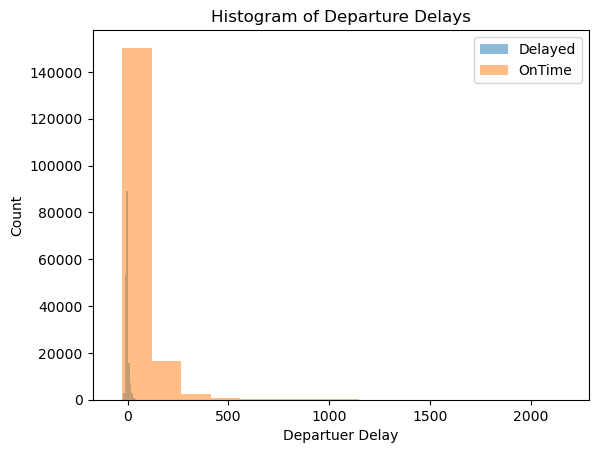

In [35]:
# Visualize Delay distributions where airplane was not delayed and was delayed

# TODO CHANGE TO BOX PLOT

# Divide flights dataset into Delayed and Ontime flights
delayed_df = flights_df[flights_df['Delayed'] ==1] 
ontime_df = flights_df[flights_df['Delayed'] == 0] 

plt.hist(ontime_df['DepDelay'], bins=15, alpha=.5)
plt.hist(delayed_df['DepDelay'], bins=15, alpha=.5)
plt.legend(['Delayed', 'OnTime'])
plt.xlabel('Departuer Delay')
plt.ylabel('Count')
plt.title('Histogram of Departure Delays')
plt.show()

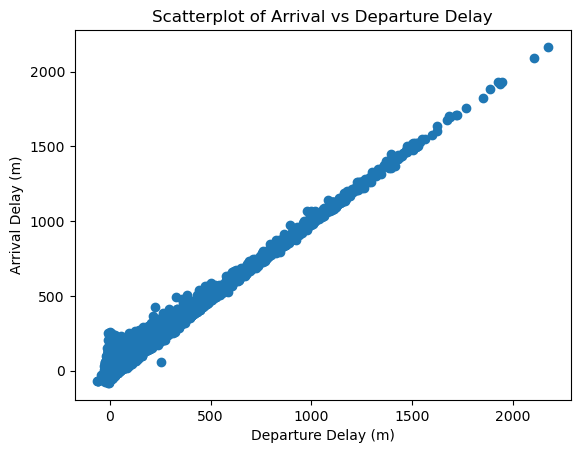

Data shows a strong linear relationship between Arrival Delay and Departuer Delay.


In [13]:
# Display Scatterplot of Arrival Delay vs. Departuer Delay
plt.scatter(flights_df['DepDelay'], flights_df['ArrDelay'])
plt.xlabel('Departure Delay (m)')
plt.ylabel('Arrival Delay (m)')
plt.title('Scatterplot of Arrival vs Departure Delay')
plt.show()

print('Data shows a strong linear relationship between Arrival Delay and Departuer Delay.')

# Logistic Regression with only DepDelay

In [49]:
# Columns to use as Features
features = ['DepDelay']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Split datset into Test / Train datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Initiate the GLM Model, fit it to data, and output the summary
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

# Predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

# Calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

# Print AUC score and Summary
print('(AUC) GLM Logistic Regression: %.4f' % auc)
print('')
print('The strong Linear relationship between Departure Delay (DepDelay) and Arrival Delay (ArrDelay) provides a 90.8% AUC score.')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257339
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0839e+05
Date:                Tue, 28 Nov 2023   Deviance:                   2.1679e+05
Time:                        16:22:45   Pearson chi2:                 2.26e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.4195
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DepDelay       0.1124      0.001    183.687      0.0

# Logistic Regression with Feature Set 1, 2, and 3

In [69]:
# Columns to use as Features
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime', 'AirTime', 'ArrTarmacTime']


# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])

# Split datset into Test / Train datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Initiate the GLM Model, fit it to data, and output the summary
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

# Predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

# Calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

# Print AUC score and Summary
print('(AUC) GLM Logistic Regression: %.4f' % auc)
print('')
print('With all 3 Feature Sets, covering from pre-departuer to arrival at the gate, we get a 95.65%  Accuracy rating.')
print('Though this is a very good AUC score, it is not very realistic for prediction prior to take-off.')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257334
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64742.
Date:                Tue, 28 Nov 2023   Deviance:                   1.2948e+05
Time:                        16:46:54   Pearson chi2:                 3.37e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5865
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

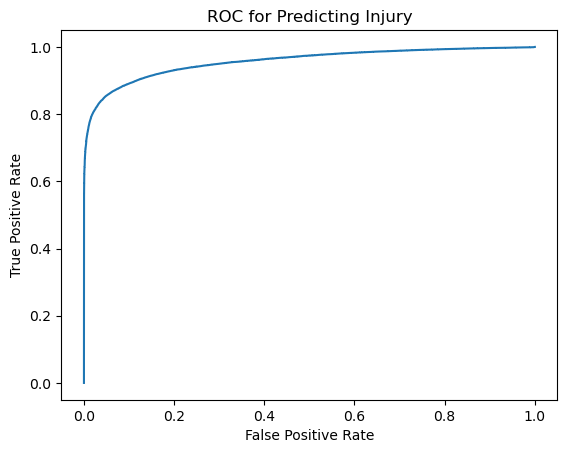

In [57]:
# Calculate AUC metrics
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)

# create ROC curve
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC for Predicting Injury")
plt.show()

# Logistic Regression with Feature Set 1 & 2

In [63]:
# Columns to use as Features
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])

# Create Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Initiate the GLM Model, fit it to data, and output the summary
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

# Predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

# Calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

# Print AUC score and Summary
print('(AUC) GLM Logistic Regression: %.4f' % auc)
print('')
print('With a reduced feature set that excludes Arrival information, we are able to get an AUC score of 92.56%.')
print('This is not quite as good, but more useful to determine the likelihood of a flight being delayed once we know the departure information.')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257336
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83434.
Date:                Tue, 28 Nov 2023   Deviance:                   1.6687e+05
Time:                        16:41:03   Pearson chi2:                 2.14e+06
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5219
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

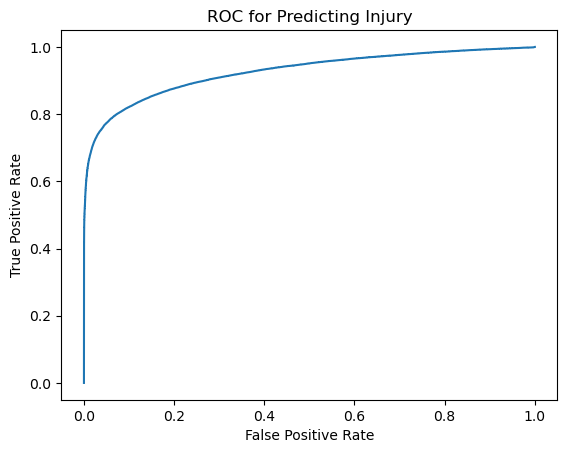

In [64]:
# Calculate AUC metrics
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)

# create ROC curve
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC for Predicting Injury")
plt.show()

# Logistic Regression with Feature Set 1

In [66]:
# Columns to use as Features
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])

# Create Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Initiate the GLM Model, fit it to data, and output the summary
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

# Predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

# Calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

# Print AUC score and Summary
print('(AUC) GLM Logistic Regression: %.4f' % auc)
print('')
print('Removing the Feature Set 2 data, we get an AUC score of 61.59%.  This is not a good score, and this model is not very useful in this state.')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257335
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7291e+05
Date:                Tue, 28 Nov 2023   Deviance:                   3.4582e+05
Time:                        16:43:26   Pearson chi2:                 2.63e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04158
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

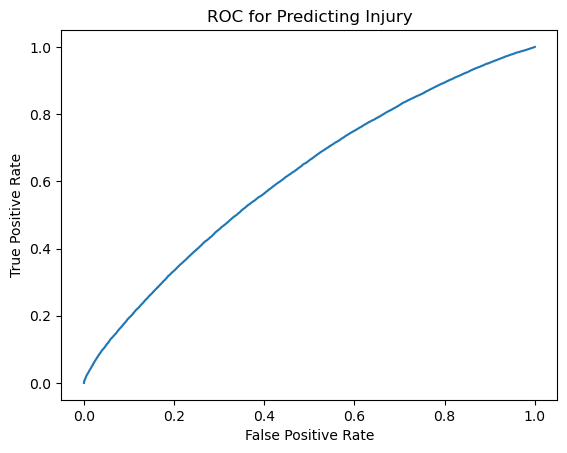

In [67]:
# Calculate AUC metrics
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)

# create ROC curve
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC for Predicting Injury")
plt.show()

# Logistic Model on Full 3-Year Data Set

In [74]:
# Load Flight and Weather Dataset
all_flights_df = pd.read_csv('../data/all_flight_data.csv')

all_flights_df.head()

MemoryError: Unable to allocate 133. MiB for an array with shape (17412876,) and data type int64